包括内容：高级外部表格引用，表格合并，CAPM，CAPM验证[Cross Sectional/Time-series Test]

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline

对于CAPM，HW5是非常好的一个例子。以下note会以HW5作为模板讲解。

多表格处理。

如果原excel文件存在多个工作表，或者在一个工作表里存在多个表格，可以在读从excel文件的pd.read_excel方程中增加系数对数据单独提取。

pd.read_excel(  
sheetname='...'[目标工作表名字，例sheetname='sheet1'],  
head=...[目标表格起始行（注意index问题），例head=0表示第一行]，  
parse_cols='...:...'[目标表格所在列范围，必要时记得包括index列。例parse_cols='A:G表示从第一列至第七列，左右都是闭区间]  
)

另外，如果缺失值超过两个，要用list的方式输入，如 na_values=[a,b,...]

对于时间数据的处理，之前在note3中提及到，比较简便的办法是直接在pd.read_excel方程中修改，通过date_parser参数进行修改。date_parser的意思是通过一个方程，输入原来的index，返还修改成时间格式的index。也就是说，date_parser需要等于只有一个自变量，也就是原index的一个方程。

问题来了，之前我们提及到的to_datetime方程可以输入很多变量，那怎么让python知道我们输入的变量是index呢？我们可以自己假设一个方程，使这个方程只有一个变量x，然后令date_parser等于它。

In [46]:
url="https://www.dropbox.com/s/yze3laidhv7gl1x/Homework4.xlsx?dl=1"

changedate = lambda x: pd.to_datetime(x,format="%Y%m")   #lambda方程，针对于变量x，x即使我们要输入到to_datetime方程中的index。

def changedate1(x):
    return pd.to_datetime(x,format="%Y%m")               #def方程也是可以的

Market=pd.read_excel(url, sheetname='Market_proxy',header=5, index_col=0,parse_dates=True, date_parser=changedate)
Market1=pd.read_excel(url, sheetname='Market_proxy',header=5, index_col=0,parse_dates=True, date_parser=changedate1)
print(Market.head(1))
print(Market1.head(1))

            Mkt-RF    RF
1926-07-01    2.96  0.22
            Mkt-RF    RF
1926-07-01    2.96  0.22


In [47]:
#提取特定的AZ:CW的数据，以及两个na_values
Size     = pd.read_excel(url, sheetname='49_Industry_Portfolios', header=6, parse_cols="AZ:CW", 
                     index_col=0, parse_dates=True, date_parser=changedate, na_values=[-99.99,-999])

#提取特定的CY:EV的数据，以及两个na_values
BM_year  = pd.read_excel(url, sheetname='49_Industry_Portfolios', header=6, parse_cols="CY:EV", 
                     index_col=0, parse_dates=True, na_values=[-99.99,-999])

print(Size.head(2))
print(BM_year.head(2)) #注意这个是年数据

             Agric   Food  Soda  Beer  Smoke   Toys    Fun  Books  Hshld  \
1926-07-01   99.80  31.19   NaN  7.12  59.72  13.00  28.64   4.33  22.27   
1926-08-01  102.06  31.15   NaN  6.75  60.47  14.12  29.34   6.50  22.13   

            Clths  ...    Boxes  Trans  Whlsl  Rtail  Meals  Banks  Insur  \
1926-07-01  18.36  ...    35.35  68.67   1.19  46.65  10.82  14.50  31.82   
1926-08-01  19.83  ...    37.86  69.79   0.90  46.57  11.00  15.17  31.65   

            RlEst    Fin  Other  
1926-07-01  22.92  10.28  24.25  
1926-08-01  23.56   9.76  25.51  

[2 rows x 49 columns]
            Agric  Food  Soda  Beer  Smoke  Toys   Fun  Books  Hshld  Clths  \
1926-01-01   0.65  0.63   NaN  2.54   0.79  1.99  0.81   4.34   0.38    0.9   
1927-01-01   0.59  0.53   NaN  1.81   0.69  2.04  0.96   2.17   0.36    0.8   

            ...    Boxes  Trans  Whlsl  Rtail  Meals  Banks  Insur  RlEst  \
1926-01-01  ...     0.97   1.41   2.35   0.44   0.66   0.66   0.62   0.88   
1927-01-01  ...     1.

合并表格。合并表格有很多种可能：https://pandas.pydata.org/pandas-docs/stable/merging.html  
上面那个链接提供了很多个方程，而且每个用法都有非常有代表性的例子帮助理解方程的逻辑，十分推荐。

pd.meger()方程，用于将两个DataFrame，按照某一个指标，左右合并。格式为pd.meger(左边DataFrame，右边DataFrame)。   

指标key作为on的参数输入。指标可以是两个Data的其中一列，甚至几列。以列作为指标的话，左边Data会调整为在指标列左边，右边Data同理。指标列必须在两列中均有出现，否则会报错。   

如果想以index为指标，那左边Data为例，则不需要写on的参数，直接写left_index=True， 右边同理。左边Data选取index作为指标，不一定要求右边表格也需要，仍然可以通过right_on='指标列名字'来选择除index以外的其他列，左边同理。  

如果合并时，两边data根据指标列存在缺失数据，默认会用Na空值填补。可以通过how修改参数:   
left: 保留左边的数据，左边data缺失时不合并右边数据。  
right:保留右边的数据，右边data缺失时不合并左边数据。  
outet:保留所有数据，  
inner:只保留左右均不为空的数据。  
如果合并时，出现了重名的列，默认左边的下标为'_x'，右边下标为'_y',可以通过suffixes=('...','...')修改下标。  

合并表格还会存在一个问题，同样为月数据的index，有的时候DataFrame是用月初记录，有时候是用月末记录，合并的时候DataFrame不会认为这两种index是同一个index，造成无法合并，解决方法很简单，只需要将其中一个index转换成另一个index就可以了，方程是pandas.tseries.offsets

In [48]:
Market.index

DatetimeIndex(['1926-07-01', '1926-08-01', '1926-09-01', '1926-10-01',
               '1926-11-01', '1926-12-01', '1927-01-01', '1927-02-01',
               '1927-03-01', '1927-04-01',
               ...
               '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
               '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
               '2015-10-01', '2015-11-01'],
              dtype='datetime64[ns]', length=1073, freq=None)

In [49]:
Market.index + pd.tseries.offsets.MonthEnd()

DatetimeIndex(['1926-07-31', '1926-08-31', '1926-09-30', '1926-10-31',
               '1926-11-30', '1926-12-31', '1927-01-31', '1927-02-28',
               '1927-03-31', '1927-04-30',
               ...
               '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
               '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30',
               '2015-10-31', '2015-11-30'],
              dtype='datetime64[ns]', length=1073, freq='M')

In [50]:
#除了convert月index，offsets还能convert很多格式的时间index，自行查看自行尝试自行检验
dir(pd.tseries.offsets)

['ABCDatetimeIndex',
 'ABCPeriod',
 'ABCSeries',
 'AbstractMethodError',
 'ApplyTypeError',
 'BDay',
 'BMonthBegin',
 'BMonthEnd',
 'BQuarterBegin',
 'BQuarterEnd',
 'BYearBegin',
 'BYearEnd',
 'BusinessDay',
 'BusinessHour',
 'BusinessHourMixin',
 'BusinessMixin',
 'BusinessMonthBegin',
 'BusinessMonthEnd',
 'CBMonthBegin',
 'CBMonthEnd',
 'CDay',
 'CacheableOffset',
 'CustomBusinessDay',
 'CustomBusinessHour',
 'CustomBusinessMonthBegin',
 'CustomBusinessMonthEnd',
 'DateOffset',
 'Day',
 'Easter',
 'FY5253',
 'FY5253Quarter',
 'Hour',
 'LastWeekOfMonth',
 'Micro',
 'Milli',
 'Minute',
 'MonthBegin',
 'MonthEnd',
 'MonthOffset',
 'Nano',
 'OutOfBoundsDatetime',
 'QuarterBegin',
 'QuarterEnd',
 'QuarterOffset',
 'Second',
 'SemiMonthBegin',
 'SemiMonthEnd',
 'SemiMonthOffset',
 'SingleConstructorOffset',
 'Tick',
 'Timedelta',
 'Timestamp',
 'Week',
 'WeekDay',
 'WeekOfMonth',
 'YearBegin',
 'YearEnd',
 'YearOffset',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',

接下来进入CAPM。CAPM一共有3个方法：  
Cross-Sectional Tests  
Fama-MacBeth Procedure  
Time-series Test  

CAPM的理论是，资产与市场的相关性能解释资产的回报率。简单来说，Cov 和 $\mu$ 成一定关系。CAPM假设，对于资产i
$$\beta_i=\frac{Cov(r_i, r_m)}{Var(r_m)}$$
有了$$\beta_i$$以后，资产的回报应该满足：
$$r_i = r_f +\beta_i(r_m - r_f)$$
或者
$$r_i^e = r_i - r_f = \beta_i (r_m -r_f ) = \beta_i r^e_m$$

CAPM并不是完美的模型，但是却是一个划时代的理论。如果类似于sharp ratio用资产自身的风险Var来度量资产回报，正如之前note4中看到，是没有任何明显的关系。CAPM划时代的提出利用beta，也就是和市场的相关性以及市场的波动性作为参数，来度量风险，得出了虽不准确但是还是不错的估计。

在CAPM中以及之后的three factors model中，我们均假设r_f为常数，在这种情况下  

$$Cov(r_i-r_f,r_m-r_f)=Cov(r_i,r_m),~~~Var(r_i-r_f)=Var(r_i)$$  

所以之后运算前，现将所有回报转化成超额回报。

In [51]:
#导入数据

Industry = pd.read_excel(url, sheetname='49_Industry_Portfolios',             #choose a sheet
                       header=6, parse_cols="A:AX",                           #set up dataframe
                       index_col=0, parse_dates=True, date_parser=changedate, #set up date format index
                       na_values=[-99.99,-999])                               #input possible na_values
#Merge
Return = pd.merge(Industry, Market, 'inner', left_index=True, right_index=True)/100 
Return.iloc[:,0:49] = Return.iloc[:,0:49].subtract(Return['RF'],axis=0)       #calculate return premium
Return.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other,Mkt-RF,RF
1926-07-01,0.0215,-0.0010,NaN,-0.0541,0.0107,0.0843,0.0228,0.4999,-0.0070,0.0786,...,-0.2401,-0.0015,0.0165,0.0439,-0.0076,0.0267,-0.0507,0.0498,0.0296,0.0022
1926-08-01,0.0198,0.0243,NaN,0.2678,0.0625,0.1656,-0.0101,0.4273,-0.0383,-0.0276,...,0.0514,-0.0100,-0.0038,0.1158,0.0232,0.0505,-0.0082,0.0651,0.0264,0.0025
1926-09-01,-0.0080,0.0135,NaN,0.0379,0.0103,0.0810,0.0619,-0.0514,0.0050,-0.0074,...,-0.0810,0.0002,-0.0079,-0.0198,0.0049,-0.0329,-0.0337,-0.0409,0.0036,0.0023
1926-10-01,-0.0078,-0.0400,NaN,-0.0363,0.0074,-0.0172,-0.0541,0.0505,-0.0500,-0.0020,...,-0.1570,-0.0252,-0.0443,-0.1214,-0.0460,-0.0606,0.0175,-0.0881,-0.0324,0.0032
1926-11-01,0.0644,0.0595,NaN,0.0698,0.0424,-0.0031,0.0151,-0.0671,-0.0085,0.0156,...,0.0436,0.0621,0.0402,-0.0328,0.0327,0.0190,0.0461,0.0369,0.0253,0.0031


返回到刚刚的CAPM模型：  

$$r_i^e = \beta_i r^e_m$$  

明显可以看到，这是一个单元线性模型，于是乎我们可以用历史数据估计beta。同时，因为CAPM假设beta是解释资产回报的唯一指标，所以，我们应该会得到一个常数项为0的单元线性模型。
要验证CAPM对不对，关键就在常数项。但是我们知道，统计结果不可能刚刚好等于0，于是我们认为，如果不显著不等于0，就认为他是等于0的。取1个资产作为例子：

In [52]:
x = sm.add_constant(Return['Mkt-RF'])
y = Return.Agric
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Agric   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     792.1
Date:                Wed, 29 Nov 2017   Prob (F-statistic):          8.33e-131
Time:                        14:00:37   Log-Likelihood:                 1538.7
No. Observations:                1069   AIC:                            -3073.
Df Residuals:                    1067   BIC:                            -3064.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.468      0.640      -0.003       0.004
Mkt-RF         0.9172      0.033     28.145      0.000       0.853       0.981
==============================================================================
Omnibus:                      401.774   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6612.739
Skew:                           1.279   Prob(JB):                         0.00
Kurtosis:                      14.913   Cond. No.                         18.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

可见对于Agric industry，Alpha很小，而且很难拒绝，所以我们可以说Agric industry是符合CAPM的。

但是一个产业符合CAPM，能否说明CAPM是正确的呢？显然不行，我们需要综合多个产业来看。  
由于在同一个时间，market premium是一样的，所以资产的超额回报是和它的beta成线性关系。换句话，所有的资产都应该在SML(Security Market Line)上。为了验证这个，我们需要记录这30个产业，在一段时间内的beta和return。  
因为记录产业的beta和return，industry就是我们新表格的index，所以我们可以通过mean table做一个初始表格

In [100]:
Estimates = pd.DataFrame(Return.iloc[:,:49].mean(),columns=['Ave'])  #只要前面49个industry
#如果不开DataFrame格式会比较头疼，所以最好还是转换成DataFrame的格式
Estimates['Beta'] = Estimates.Ave * 0
Estimates.head()

,Ave,Beta
Agric,0.006819,0.0
Food,0.007215,0.0
Soda,0.007834,0.0
Beer,0.009352,0.0
Smoke,0.008880,0.0


以industry为索引，对每一个资产做回归分析，并记录Beta，假设Beta在这段时间是不变的。

In [101]:
x=sm.add_constant(Return['Mkt-RF'])

for industry in Estimates.index:                
    y=Return[industry]
    results = sm.OLS(y,x,missing='drop').fit()
    # record slope estiamtes
    Estimates.set_value(industry,'Beta',results.params[1])      
    #注意因为这里很有可能会有数字index和字母index的混合使用，所以用set_value比iloc,或loc更好。

In [102]:
Estimates.head()

,Ave,Beta
Agric,0.006819,0.917173
Food,0.007215,0.728618
Soda,0.007834,0.840749
Beer,0.009352,0.946365
Smoke,0.008880,0.631790


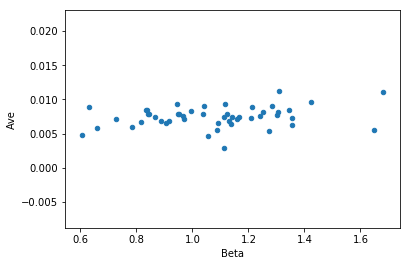

In [56]:
Estimates.plot(x='Beta',y='Ave',kind='scatter')
#看起来似乎是在一条直线上，但是不知道截距是不是为0，最简单的办法就是做一下回归分析

In [57]:
x = sm.add_constant(Estimates.Beta)
y = Estimates.Ave
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Ave   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2.687
Date:                Wed, 29 Nov 2017   Prob (F-statistic):              0.108
Time:                        14:00:38   Log-Likelihood:                 250.03
No. Observations:                  49   AIC:                            -496.1
Df Residuals:                      47   BIC:                            -492.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.001      5.855      0.000       0.004       0.008
Beta           0.0015      0.001      1.639      0.108      -0.000       0.003
==============================================================================
Omnibus:                        4.612   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                3.587
Skew:                          -0.474   Prob(JB):                        0.166
Kurtosis:                       3.927   Cond. No.                         9.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

可以看到虽然t很小，但是却是显著的。以上就是我们的__Cross-sectional regression method__了。然而这个方法有个问题，那就是误差太大，因为样本只有49个数据。这个误差实际上是t-test的误差，在之前statistic里面讲到过，t-distribution实际上和样本量是有关的。  
于是乎我们想，不如我们假设这段时间的beta是固定的，那么对于每一个时间点，我们都能做一个估计，看看alpha的大小，这样再来验证alpha是否显著，不就大大的增加了样本量了么，同时我们也可以尝试解释因为时间点不同，产生的abnormal return。于是乎我们就有了新的模型  

$$r_{i,t}=\gamma_{0,t}+\gamma_{M_t}\beta_{i,M}+\eta_{i,t}$$  

其中，$\gamma_0$是每个时期的abnormal return， $\gamma_M$是每个时期的市场超额回报，$\eta$就是误差。在这个模型下，如果CAPM成立，我们应该得到如下两个结果  
$\gamma_0=0$  
$\gamma_M>0$

这个时候，有多少时间就有多少组拟合数据，所以这个时候我们用来记录的表格应该是以时间为行标签，正好和原数据一样，所以我们用原数据做一个初始表格

In [81]:
Gamma = Return.iloc[:,:2]*0 #同时引入两列格式就是DataFrame了，不需要像上面那样做转化。
Gamma.columns=['gamma0','gammaM']
Gamma.head()

,gamma0,gammaM
1926-07-01,0.0,-0.0
1926-08-01,0.0,0.0
1926-09-01,-0.0,0.0
1926-10-01,-0.0,-0.0
1926-11-01,0.0,0.0


以时间作为索引，对每个时期的回报做估计，记录两个gamma

In [105]:
x = sm.add_constant(Estimates.Beta)
for date in Gamma.index:
    y = Return.iloc[:,:49].loc[date]
    results = sm.OLS(y,x,missing='drop').fit()
    Gamma.set_value(date,'gamma0',results.params[0])
    Gamma.set_value(date,'gammaM',results.params[1]) #这里就出现时间和字符index混合的情况，只能用set_value

In [107]:
Gamma.head()

,gamma0,gammaM
1926-07-01,0.030723,-0.001180
1926-08-01,0.045367,-0.003406
1926-09-01,0.036414,-0.038136
1926-10-01,0.030804,-0.062423
1926-11-01,0.053362,-0.023481


In [110]:
#sample size
n = Gamma.shape[0]
n

1069

In [121]:
#mean
mu = Gamma.mean()
mu

gamma0    0.005196
gammaM    0.002314
dtype: float64

In [122]:
#std
std = Gamma.std()
std

gamma0    0.062253
gammaM    0.083695
dtype: float64

In [123]:
#std err
stderr = std/np.sqrt(n)
stderr

gamma0    0.001904
gammaM    0.002560
dtype: float64

In [125]:
#test
t=mu/stderr
print(t)
print(1-stats.t.cdf(t,n-1))

gamma0    2.728716
gammaM    0.904123
dtype: float64
[ 0.00323127  0.18306705]


结果和之前不太一样，但是还是可以看到abnormal return仍然是统计上显著。

 这两个测试方法基本上是一个逻辑，也就是通过统计方法，也就是t-test，测量alpha是否是显著大于0.换句话说，有一堆资产的回报率，有rf rate，有market premium，你就可以跑这两个test了，区别只是如何得到alpha和alpha的标准误差是什么。 但是还有一个方法__Fama-MacBeth Procedure__，这个方法和上述方法方式不太一样。Fama-MacBeth Procedure的逻辑是，如果存在另一个factors，能相对于CAPM而言，更好的估计回报，那么CAPM就不成立了。  模型如下：  
 
$$R_{i,t}=\gamma_{0,t} + \gamma_{M,t}\beta_{i,M} + \gamma_{X,t}X_t + \eta_{i,t}$$

这个方法看似很难，因为要找到别的factors,但是这就是F-F Three Factors Model验证的一种方式。Notebook只是随便选择一个因子，也就是他们的排名，来尝试了一下，并没有什么特别的含义，需要知道的是如何解释结果。如果$\gamma_X,t$是统计显著的，就说明X_t能有效的解释一部分回报，说明CAPM是错的。  

CAPM这么容易被拒绝，原因就是它的假设：Beta是__唯一__解释回报的因子。

#以下这段是我之前写date index的时候的草稿，懒得删了。

In [59]:
url="https://www.dropbox.com/s/9346pp2iu5prv8s/MonthlyFactors.csv?dl=1"
Data = pd.read_csv(url, index_col=0, parse_dates=True,na_values=-99)
Data.head()

,RF,MKT,SMB,HML,Mom
Date,,,,,
1926-07-31,0.22,3.18,-2.30,-2.87,NaN
1926-08-31,0.25,2.89,-1.40,4.19,NaN
1926-09-30,0.23,0.59,-1.32,0.01,NaN
1926-10-31,0.32,-2.92,0.04,0.51,NaN
1926-11-30,0.31,2.84,-0.20,-0.35,NaN


In [60]:
type(Data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [61]:
Data.index.year

Int64Index([1926, 1926, 1926, 1926, 1926, 1926, 1927, 1927, 1927, 1927,
            ...
            2016, 2016, 2016, 2016, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='Date', length=1092)

In [62]:
Data.index.month

Int64Index([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
            ...
             9, 10, 11, 12,  1,  2,  3,  4,  5,  6],
           dtype='int64', name='Date', length=1092)

In [63]:
Data.index.weekday_name

Index(['Saturday', 'Tuesday', 'Thursday', 'Sunday', 'Tuesday', 'Friday',
       'Monday', 'Monday', 'Thursday', 'Saturday',
       ...
       'Friday', 'Monday', 'Wednesday', 'Saturday', 'Tuesday', 'Tuesday',
       'Friday', 'Sunday', 'Wednesday', 'Friday'],
      dtype='object', name='Date', length=1092)

注意一个问题！Data.index的数据类型是Datatimes,但是Data.index.year等等都不是Datatimes, 如果你需要将新的index转换成时间格式，你需要to_datatime()方程. 这个方程可以讲一个数字转换成日期，需要填写你数据的格式，如果年月日就是"%Y%m%d"，注意大小写，
http://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.to_datetime.html

In [64]:
Data
pd.to_datetime(Data.index.year, format="%Y")

DatetimeIndex(['1926-01-01', '1926-01-01', '1926-01-01', '1926-01-01',
               '1926-01-01', '1926-01-01', '1927-01-01', '1927-01-01',
               '1927-01-01', '1927-01-01',
               ...
               '2016-01-01', '2016-01-01', '2016-01-01', '2016-01-01',
               '2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
               '2017-01-01', '2017-01-01'],
              dtype='datetime64[ns]', name='Date', length=1092, freq=None)

groupby()是一个规则，按照某一个指标进行分组。这个指标是DataFrame的一个子方程,当你用一个一个Dataframe的名字.groupby()的时候就是针对这个Dataframe进行操作。groupby()需要输入一个指标，这个指标可以是一个column，或者一个index的名字，系统将为数据进行分组。

In [65]:
Data_Return=Data+1

In [66]:
Data_Return['year']=Data.index.year
Data_Return.head()

,RF,MKT,SMB,HML,Mom,year
Date,,,,,,
1926-07-31,1.22,4.18,-1.30,-1.87,NaN,1926
1926-08-31,1.25,3.89,-0.40,5.19,NaN,1926
1926-09-30,1.23,1.59,-0.32,1.01,NaN,1926
1926-10-31,1.32,-1.92,1.04,1.51,NaN,1926
1926-11-30,1.31,3.84,0.80,0.65,NaN,1926


In [67]:
type(Data_Return.groupby('year'))

pandas.core.groupby.DataFrameGroupBy

可以看到这个type是个奇奇怪怪的东西。你可以在这个规则上进行操作

In [68]:
Data_yReturn=(Data_Return.groupby('year')).prod()
Data_yReturn.head()

,RF,MKT,SMB,HML,Mom
year,,,,,
1926,4.151740,-7.433957e+02,-0.132907,-9.428589,NaN
1927,15.575490,1.510011e+06,-43.873508,3.513067,1022.485197
1928,20.649620,3.857799e+05,-90.803239,0.371754,9859.368858
1929,50.072691,5.586546e+07,-145.846434,-77.658654,-76383.886815
1930,8.679985,-9.260956e+06,-435.097360,0.005806,995062.679800


Data_yReturn=(Data_Return.groupby('year')).prod()
这一句code的逻辑是，先对Data_Return按照‘year’这个column或index进行分类，分类后每组做prod()的运算，最后把结果写到Data_yReturn这个DataFrame里。

注意，这个时候新的DataFrame的index肯定就是你刚刚分组的那个column或者index了。那么数据类型也是一样的。

所以一些对于datatime的操作，这个时候新的index是不适用的。

In [69]:
Data_Return.index.year

Int64Index([1926, 1926, 1926, 1926, 1926, 1926, 1927, 1927, 1927, 1927,
            ...
            2016, 2016, 2016, 2016, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='Date', length=1092)

In [70]:
Data_yReturn.index.year

AttributeError: 'Int64Index' object has no attribute 'year'

通过转换，又可以重新引用

In [ ]:
Data_yReturn.index=pd.to_datetime(Data_yReturn.index, format='%Y')
Data_yReturn.index.year